### Simple Example for sea-level rise projections following the methodology of Mengel et al., PNAS (2016).

Please cite if you make use of this code.
This notebook follows `src/create_projections.py`, which was used for the probalistic sea level projections in the paper. We here demonstrate a slightly simplier version without global mean temperature (gmt) sampling, as the gmt ensemble is not openly available.

In [2]:
%matplotlib inline

In [3]:
""" matthias.mengel@pik
"""
import os, glob, sys
import numpy as np

import dimarray as da
import cPickle as pickle
sys.path.append("../src/")
import contributor_functions as cf; reload(cf)
import sealevel as sl; reload(sl)
import plotting; reload(plotting)

# choose here which contributions to project (all as in paper)
project_these = ["thermexp","gic","gis_smb","gis_sid","ant_smb","ant_sid"]

# period for which sea-level projections are generated (1900-2100 as in paper)
proj_period= np.arange(1900,2101,1)

# the number of monte carlo samples (less for testing, 10000 in paper)
nrealizations = 100
realizations = np.arange(nrealizations)

## the calibration data each sea level contributor is here (as used in paper)
calibdatadir = "../data/calibration/"
ipccdatadir = '../data/input/ipcc_ar5/'

In [4]:
## get IPCC AR5 global mean temperature pathways for each RCP scenario
## they can be downloaded from
## http://www.ipcc.ch/report/ar5/wg1/docs/ar5_wg1_annexI_all.zip

## define 1951-1980 to preindustrial (1850-1860)
## global temperature increase based on hadCrut v4.0 data
## see src/get_gmt_data.py for calculation
preind_to_1951_1980 = 0.2640

tas_data = {}
for scen in ['rcp26','rcp45','rcp60','rcp85']:
    try:
        tas = np.loadtxt(ipccdatadir+'WGIAR5_FD_AnnexI_series_tas_modelmean_'+
                            scen+'_world_annual.txt')
    except IOError:
        raise IOError, ("IPCC global mean temperature data missing, "
                        "please run src/download_input_data.py")
        
    tasd = da.DimArray(tas[:,1],dims="time",axes=tas[:,0])
    
    ## create anomaly to hadcrutv4 1850-1860 mean
    ## which was used throughout the study as "relative to preindustrial"
    tas_data[scen] = tasd - tasd[1951:1980].mean() + preind_to_1951_1980

Create the sea level projections by sampling probabilstically from the several sea level functions and their calibrations. This is a part of src/create_projections.py that was used for the paper.

In [5]:
# see also src/do_projections.py
projection_data = {}

## only for mapping the different names of RCP scenarios
nd = {"rcp26":"RCP3PD",'rcp45':"RCP45",'rcp85':"RCP85"}

#import get_magicc_gmt_data as mag; reload(mag)

for scen in ["rcp26",'rcp45','rcp85']:#,"RCP45","RCP85"]:

    print "##",scen
    projection_data[nd[scen]] = {}
    gmt = tas_data[scen]
    ## sampling from MAGICC 600 member ensemble as in paper
    ## (not done here as data not openly available.)
    #gmt = mag.magicc_gmt[nd[scen]]

    for i,contrib_name in enumerate(project_these):

        print "conribution", contrib_name
        calibdata = pickle.load(open(calibdatadir+contrib_name+".pkl","rb"))
        proj = np.zeros([len(proj_period),nrealizations])

        for n in realizations:
            proj[:,n] = sl.project(gmt,proj_period,calibdata,n+1)

        pdata = da.DimArray(proj, axes=[proj_period,realizations],
                            dims=["time","runnumber"])
        projection_data[nd[scen]][contrib_name] = pdata

## rcp26
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid
## rcp45
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid
## rcp85
conribution thermexp
conribution gic
conribution gis_smb
conribution gis_sid
conribution ant_smb
conribution ant_sid


### Figure 3
Plot like Fig. 3 in the PNAS manuscript. Note the thinner uncertainty bands for certain contributions as we do not sample climate uncertainty here (MAGICC ensemble is not publicly available).

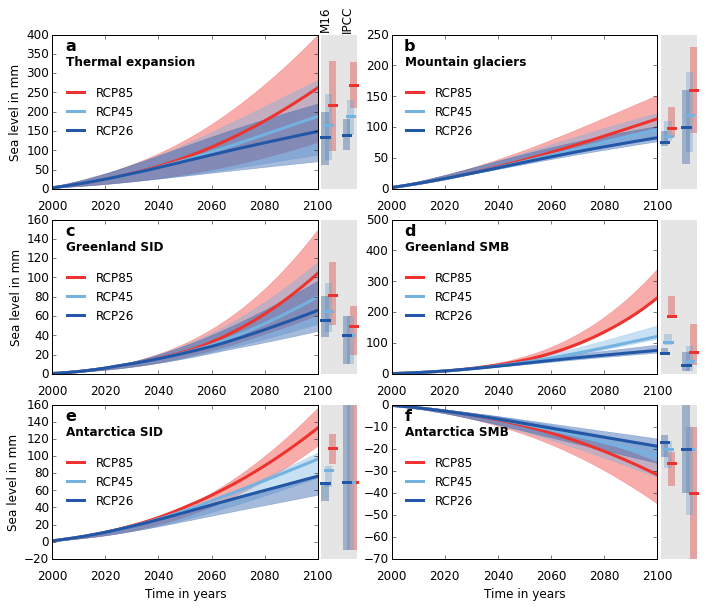

In [7]:
plotting.fig3(projection_data)

### Figure 4
Plot like Fig. 4 in the PNAS manuscript. Note the thinner uncertainty bands due to the missing sampling of climate uncertainty, i.e. not including the global mean temperature ensemble.

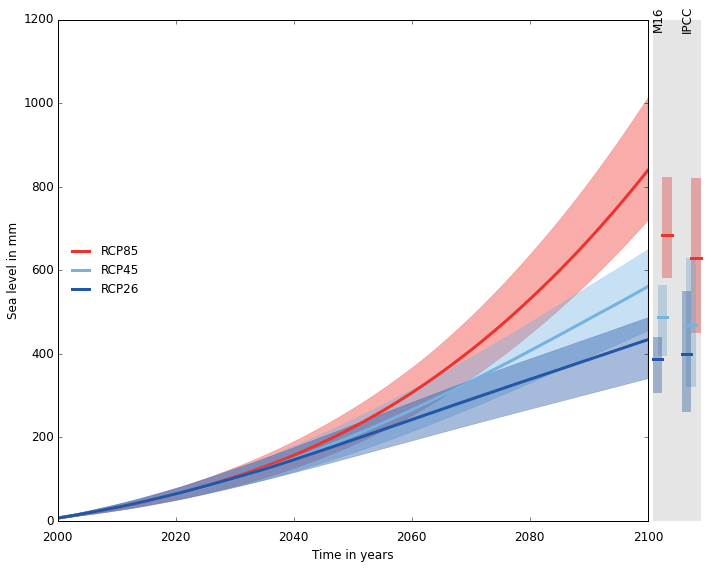

In [8]:
plotting.fig4(projection_data)